## Cryogenic Materials Repository Tutorial
Author: Henry Nachman

Created: 22 July 2024 

Welcome to the Cryogenic Materials Repository - created by researchers at the University of Texas and supported by the CMB-S4 collaboration.

This notebook will walk you through the basics of using this repository using Python. By the end of this short tutorial you should be prepared to view the thermal conductivity fit of a material, and calculate and integrate the thermal conductivity using the fit.

First, let's start by resolving the necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd

# Now we need to make sure that the parent folder is added to our path
# These paths may need to be adjusted on your machine

abspath = os.path.abspath("RepositoryTutorial.ipynb")
file_path = os.path.split(abspath)[0]
parent_dir = os.path.dirname(file_path)
sys.path.insert(0, parent_dir)

from thermal_conductivity.tc_utils import *
from thermal_conductivity.tc_tools import *

Let's start by trying to load the fit compilation files.

In [2]:
# The following code is a 'smart' way of finding the most recently uploaded compilation file
all_files       = os.listdir(parent_dir)
exist_files     = [file for file in all_files if file.startswith("tc_fullrepo")]
tc_file_date    = exist_files[0][-12:-4]

TCdata = np.loadtxt(f"{path_to_tcFiles}{os.sep}tc_fullrepo_{tc_file_date}.csv", dtype=str, delimiter=',') # imports compilation file csv

Luckily, several functions have already been made to easily use the repository compilation files. For more information see the tc_tools.py file.

Let's generate a list of the available material names in the compilation file.

In [3]:
mat_names = [str(mat) for mat in TCdata[1:, 0]] # loop through all materials in the file
print(mat_names)

['Aluminum', 'Aluminum_1100', 'Aluminum_3003F', 'Aluminum_5083O', 'Aluminum_6061T6', 'Aluminum_6063T5', 'Beryllium_Copper', 'Brass', 'CFRP', 'CFRP_Clearwater', 'CFRP_DPP', 'CFRP_Graphlite', 'Constantan', 'Copper-Nickel', 'Corian', 'Corian', 'G10_CR_Normal', 'G10_CR_Warp', 'G10_FR4', 'G10_parent', 'Glass_FabricPolyester_He_warp', 'Glass_FabricPolyester_Ni_normal', 'Glass_FabricPolyester_Ni_warp', 'Graphite', 'Graphite_a', 'Graphite_brad', 'Graphite_p', 'Inconel_718', 'Invar_Fe36Ni', 'Kapton', 'Kaptona', 'Ketron', 'Kevlar49_Composite_Aramid', 'Kevlar49_Fiber_Aramid', 'Lead', 'Macor', 'Manganin', 'Molybdenum', 'MylarPET', 'NbTi', 'Nichrome', 'Nickel_Steel_Fe_2.25_Ni', 'Nickel_Steel_Fe_3.25_Ni', 'Nickel_Steel_Fe_5.0_Ni', 'Nickel_Steel_Fe_9.0_Ni', 'Nylon', 'Phosphorbronze', 'Platinum', 'Polystyrene_1.99_lbft3_Freon', 'Polystyrene_2.0_lbft3', 'Polystyrene_3.12_lbft3', 'Polystyrene_6.24_lbft3', 'Polyurethane_1.99_lbft3_Freon', 'Polyurethane_2.0_lbft3_CO2', 'Polyurethane_3.06_lbft3_He', 'Polyu

In [4]:
# Select a material of interest
material_of_interest = "Aluminum"
mat_parameters = get_parameters(TCdata, mat = material_of_interest)
print(mat_parameters)

{'fit_type': np.str_('Nppoly'), 'fit_range': array([0.264, 1.061]), 'low_param': [-18.5104, 29.2536, 2.07719, -2.22005], 'hi_param': [], 'erf_param': 0.0}


You'll notice that the return of 'get_parameters' is a dictionary of the fit parameters. Now, let's try and use that information to plot the fit for Stainless Steel.

Some fit functions take additional parameters - see the fit_types file for more info. They must be added manually and are not assumed in this tutorial.

<function Nppoly at 0x000002C84F2C6D40>
[0.264 1.061]


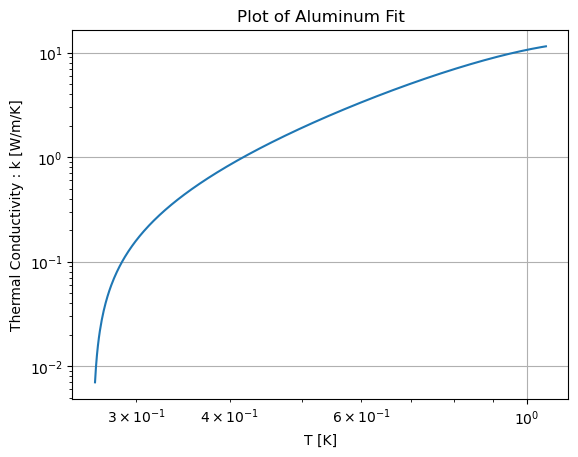

In [5]:
func_type = get_func_type(mat_parameters["fit_type"])
print(func_type)
fit_range = mat_parameters["fit_range"]
print(fit_range)
# Let's make our plotting range the listed fit range
T_range = np.linspace(fit_range[0], fit_range[1], 1000)

# Now let's use the fit to get the thermal conductivity values over the range
# Luckily, every function type is defined in such a way to readily accept the parameter dictionary as it was defined above
y_vals = func_type(T_range, mat_parameters)

# Plotting
plt.plot(T_range, y_vals)
plt.semilogy()
plt.semilogx()
plt.title(f"Plot of {material_of_interest} Fit")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.grid()
plt.show()

Great! Now that we know how to get the thermal conductivity at a given temperature value it is relatively straightforward to integrate over a specified range.

The provided function 'get_conductivity_integral' uses the built-in numpy.trapz function to calculate the integral.

In [6]:
T_low, T_high = [0.3, 1.0]
tc_integral = get_conductivity_integral(T_low, T_high, material_of_interest)

print(f"{tc_integral} W/m")

3.2246571600008185 W/m


Just for fun, let's see what that region looks like on the plot

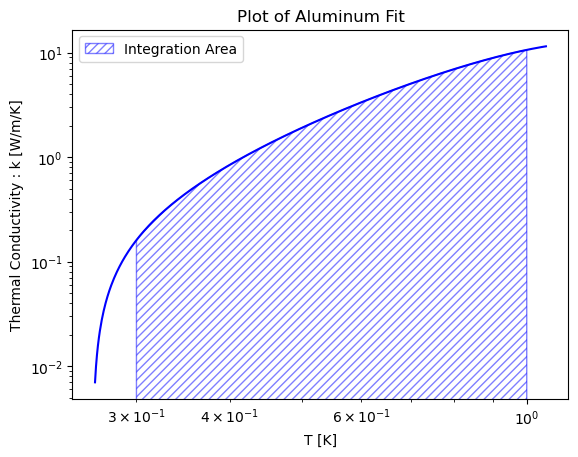

In [7]:
# Plotting
fill_between_range = np.linspace(T_low, T_high, 1000)
plt.plot(T_range, y_vals, color="b")
plt.fill_between(fill_between_range, np.zeros(len(fill_between_range)), func_type(fill_between_range, mat_parameters),
                 hatch="////", alpha = 0.5, edgecolor = 'b', facecolor="w",
                 label="Integration Area")
plt.semilogy()
plt.semilogx()
plt.legend()
plt.title(f"Plot of {material_of_interest} Fit")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.show()

Many of the materials have a number of different available fits often spanning a unique temperature range, or with a unique fit structure. In this case, it can be useful to select which fit to use.

In [17]:
# Again we will specify the material of interest
material_of_interest = "Aluminum_1100"

# Let's pull the file with the fits for this material
path_to_material = os.path.join(parent_dir, "thermal_conductivity", "lib", material_of_interest)
material_allfits = os.path.join(path_to_material, "all_fits.csv")

TCdata = np.loadtxt(material_allfits, dtype=str, delimiter=',')  # imports material specific fits file csv
available_fits = TCdata[1:, 0]  # The first column contains the fit names
# Show the available fits for this material
print("Available fits for this material:", available_fits)

Available fits for this material: ['raw_fit' 'NIST_fit']


Select a fit and display the parameters

<function Nppoly at 0x000002C84F2C6D40>
[0.264 1.061]
<function polylog at 0x000002C84F2C6DE0>
[  4. 300.]


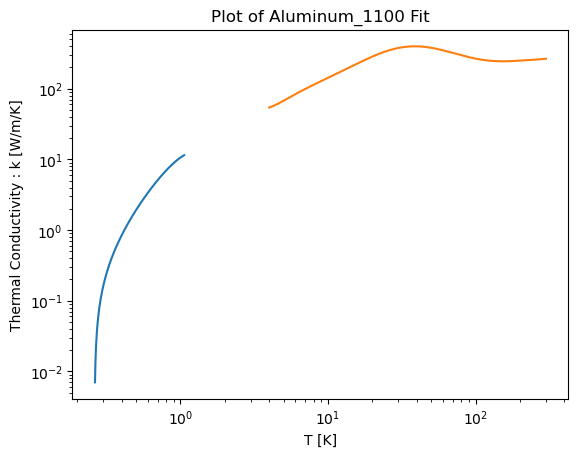

In [19]:
# specify_fit = "Aluminum_6061T6_NIST_fit"  # Specify the fit you want to use
for specify_fit in available_fits:
    mat_parameters = get_parameters(TCdata, mat = specify_fit)
    func_type = get_func_type(mat_parameters["fit_type"])
    print(func_type)
    fit_range = mat_parameters["fit_range"]
    print(fit_range)
    # Let's make our plotting range the listed fit range
    T_range = np.linspace(fit_range[0], fit_range[1], 1000)

    # Now let's use the fit to get the thermal conductivity values over the range
    # Luckily, every function type is defined in such a way to readily accept the parameter dictionary as it was defined above
    y_vals = func_type(T_range, mat_parameters)

    # Plotting
    plt.plot(T_range, y_vals)
    plt.semilogy()
    plt.semilogx()
    plt.title(f"Plot of {material_of_interest} Fit")
    plt.xlabel("T [K]")
    plt.ylabel("Thermal Conductivity : k [W/m/K]")
    plt.grid()
plt.show()


54322.6997742885 W/m


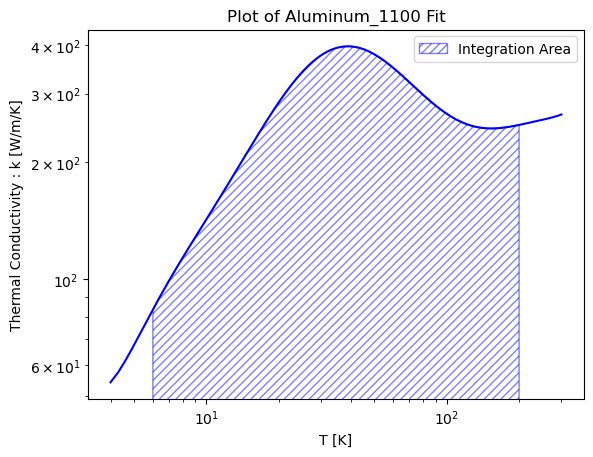

In [21]:
T_low, T_high = [6.0, 200.0]
tc_integral = get_conductivity_integral(T_low, T_high, material_of_interest, specify_fit=specify_fit)

print(f"{tc_integral} W/m")

fill_between_range = np.linspace(T_low, T_high, 1000)
plt.plot(T_range, y_vals, color="b")
plt.fill_between(fill_between_range, np.zeros(len(fill_between_range)), func_type(fill_between_range, mat_parameters),
                 hatch="////", alpha = 0.5, edgecolor = 'b', facecolor="w",
                 label="Integration Area")
plt.semilogy()
plt.semilogx()
plt.legend()
plt.title(f"Plot of {material_of_interest} Fit")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.show()

Many of the materials also come with an interpolation function that can be used to estimate the thermal conductivity up to room temperature. 

Interpolation valid range: 0.264 K to 300.0000000000001 K


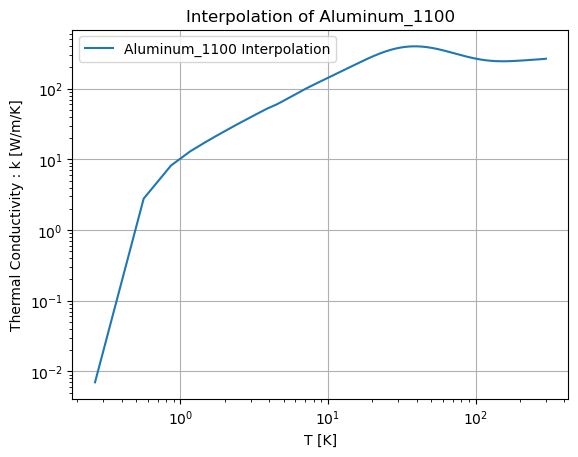

In [23]:
material_interp_func = get_interpolation(path_to_material)

print(material_interp_func)
print(f"Interpolation valid range: {material_interp_func.x[0]} K to {material_interp_func.x[-1]} K")

x_plot = np.linspace(material_interp_func.x[0], material_interp_func.x[-1], 1000)
y_plot = material_interp_func(x_plot)
plt.plot(x_plot, y_plot, label=f"{material_of_interest} Interpolation")
plt.semilogy()
plt.semilogx()
plt.legend()
plt.title(f"Interpolation of {material_of_interest}")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.grid()
plt.show()